This notebook focuses on getting the ICA fitting down using Amy's predetermined weights.

In [54]:
from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import richardsplot
import os

#Use the package that Amy used for determining weights
from lmfit import minimize, Parameters

In [55]:
#Load the metadata of all 8403 objects
dat = pd.read_csv("data/grdr7.8403col.radec.platemjdfiber.csv")
dat.head()

,name,RA_1,Dec_1,RA_2,DEC_2,REDSHIFT,PLATE,FIBER,MJD
0,095004.94-002012.2,147.520612,-0.336744,147.520615,-0.336744,1.7756,267,275,51608
1,095938.28-003500.8,149.909527,-0.583571,149.909531,-0.583571,1.8766,268,59,51633
2,101033.44-004724.5,152.639355,-0.790145,152.639359,-0.790145,1.6675,270,213,51909
3,101100.92+002039.4,152.753859,0.344291,152.753860,0.344291,1.7487,270,491,51909
4,101826.85-000951.1,154.611911,-0.164201,154.611908,-0.164201,1.8156,271,152,51883


In [56]:
z     = dat[["REDSHIFT"]].values.flatten()
plate = dat[["PLATE"]].values.flatten()
mjd   = dat[["MJD"]].values.flatten()
fiber = dat[["FIBER"]].values.flatten()

Load in all the data.

In [57]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
spectra = np.array([])
wave    = np.array([])
ivar    = np.array([])
N = 0

for red, pl, mj, fib in zip(z, plate, mjd, fiber):
    try:
        hdul_spec = fits.open("data/VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        print("data/VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>1470) & (sdss_wave<2875))
    sdss_flux  = sdss_flux[wavemask]
    #sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()
    
    if len(spectra) < 1:
        spectra = np.append(spectra, sdss_flux)
        wave = np.append(wave, sdss_wave)
        ivar = np.append(ivar, sdss_ivar)
    else:
        if len(sdss_flux) >= 2913:
            spectra = np.vstack((spectra, sdss_flux[:2913])) #Some might have one extra pixel
            wave = np.vstack((wave, sdss_wave[:2913]))
            ivar = np.vstack((ivar, sdss_ivar[:2913]))
            
    N+=1
    if N>25: break #Just because this cell takes a while to run and we don't need all spectra since we're not deriving our own components 

Not sure why 3 spectra are missing, but that doesn't really matter right now.  Note that it takes much more time to load in the data than it does to actually run ICA on it...

Load in each set of components

In [58]:
cmod = pd.read_csv("ICAcomponents_amy/amy_12603000_10c_180421.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7","c8","c9","c10"])

clow = pd.read_csv("ICAcomponents_amy/amy_12753000_lowew_10c_181101_v1.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7","c8","c9","c10"])

chigh = pd.read_csv("ICAcomponents_amy/amy_12653000_hew_hsn_7c_190302.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7"])

chigh.head()

,c1,c2,c3,c4,c5,c6,c7
0,0.029352,21.131907,1.849054,6.627145,3.014905,-0.692857,0.047240
1,0.040435,21.345699,1.454935,6.415685,2.845428,-0.676061,0.236393
2,0.050010,21.377104,1.303095,6.243556,2.912823,-0.646095,0.208662
3,0.062440,21.326774,1.182024,6.375846,2.807746,-0.699397,0.145732
4,0.083303,21.481439,0.818819,6.176292,2.792313,-0.817434,0.010118


In [59]:
wave_mod = pd.read_csv("ICAcomponents_amy/wav_12603000.dat", names=["wave"])
wave_low = pd.read_csv("ICAcomponents_amy/wav_12753000.dat", names=["wave"])
wave_high= pd.read_csv("ICAcomponents_amy/wav_12653000.dat", names=["wave"])

In [60]:
modmask = np.array(((wave_mod>1470) & (wave_mod<2875))).flatten()
lowmask = np.array(((wave_low>1470) & (wave_low<2875))).flatten()
highmask= np.array(((wave_high>1470) & (wave_high<2875))).flatten()

wave_mod = np.array(wave_mod[modmask]).flatten()
wave_low = np.array(wave_low[lowmask]).flatten()
wave_high= np.array(wave_high[highmask]).flatten()

In [61]:
#make an array of the components to feed to minimize
components_mod = np.array([])
components_low = np.array([])
components_high= np.array([])

for n,i in enumerate(cmod):
    if n==0:
        components_mod = np.append(components_mod, cmod[[i]].values.flatten().astype(float)[modmask])
        components_low = np.append(components_low, clow[[i]].values.flatten().astype(float)[lowmask])
        components_high= np.append(components_high, chigh[[i]].values.flatten().astype(float)[highmask])
    elif n < 7:
        components_mod = np.vstack((components_mod, cmod[[i]].values.flatten().astype(float)[modmask]))
        components_low = np.vstack((components_low, clow[[i]].values.flatten().astype(float)[lowmask]))
        components_high= np.vstack((components_high, chigh[[i]].values.flatten().astype(float)[highmask]))
    else:
        components_mod = np.vstack((components_mod, cmod[[i]].values.flatten().astype(float)[modmask]))
        components_low = np.vstack((components_low, clow[[i]].values.flatten().astype(float)[lowmask]))

In [62]:
#Wrap it all in a function

def residual(params, comps, data, eps_data):
    model = sum(params[w].value*comps[n] for (n, w) in enumerate(params))
    return (data-model)**2 * eps_data

def ica_fit(components, spectrum, ivar):
    params = Parameters()
    for i in range(len(components)):
        params.add('W%d' % (i+1), value=0)
        
    return minimize(residual, params, args=(components, spectrum, ivar), method="lbfgsb")

Now can easily wrap this in a loop.  Amy says she used chi-square to determine which set of components provided the best fit, so we should do the same.

(Note also that the weights for mine were so big because I was determining the components *with the normalized spectra*.  Amy's components seem to be in real units, so it makes sense that the weights on them when applied to the normalized spectra are much smaller.)

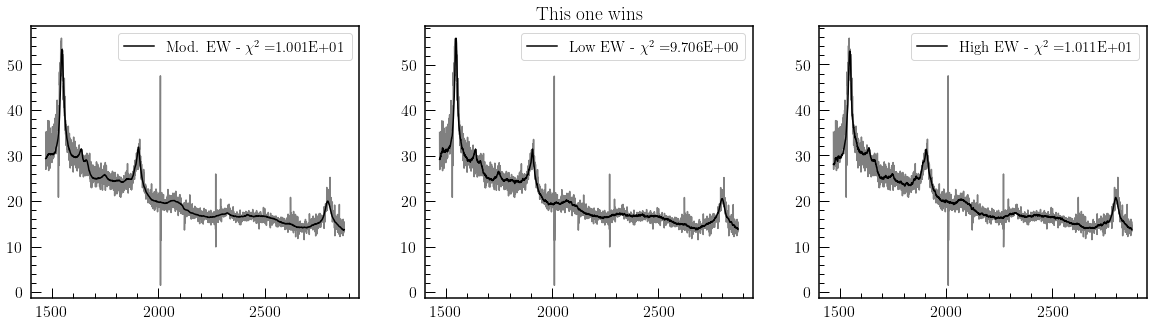

In [63]:
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(20,5))

fit_mod   = ica_fit(components_mod, spectra[0], ivar[0])
weights_mod = []
for i in fit_mod.params: weights_mod.append(fit_mod.params[i].value)
mod_chisq = fit_mod.redchi
ax1.plot(wave_mod, spectra[0], '-', c='gray')
ax1.plot(wave_mod, np.dot(weights_mod, components_mod), '-k', label="Mod. EW - $\chi^2=$%.3E" % (mod_chisq))
ax1.legend(loc="best", prop={"size":15})

fit_low   = ica_fit(components_low, spectra[0], ivar[0])
weights_low = []
for i in fit_low.params: weights_low.append(fit_low.params[i].value)
low_chisq = fit_low.redchi
ax2.plot(wave_low, spectra[0], '-', c='gray')
ax2.plot(wave_low, np.dot(weights_low, components_low), '-k', label="Low EW - $\chi^2=$%.3E" % (low_chisq))
ax2.legend(loc="best", prop={"size":15})

fit_high   = ica_fit(components_high, spectra[0], ivar[0])
weights_high = []
for i in fit_high.params: weights_high.append(fit_high.params[i].value)
high_chisq = fit_high.redchi
ax3.plot(wave_high, spectra[0], '-', c='gray')
ax3.plot(wave_high, np.dot(weights_high, components_high), '-k', label="High EW - $\chi^2=$%.3E" % (high_chisq))
ax3.legend(loc="best", prop={"size":15})

if mod_chisq < low_chisq and mod_chisq < high_chisq:
    ax1.set_title("This one wins")
elif low_chisq < mod_chisq and low_chisq < high_chisq:
    ax2.set_title("This one wins")
elif high_chisq < low_chisq and high_chisq < mod_chisq:
    ax3.set_title("This one wins")

It looks like they all do a good job.  But then again, this is a pretty clean spectrum to begin with.  Try on some others.

Gordon says we can't really use just the ICA weights for analysis since different objects use different sets of components.  But could we just use the same components anyway??  They may not produce the most accurate reconstructions, but even if the reconstruction isn't quite right, we may still be able to draw physical information from the weights applied...  Still gonna need to see how bad some of the "moderate EW" components reconstruct low+high EW objects...

We have >8000 to look at, but show the first say 15 in this notebook.  Wrap the above cell in a loop.

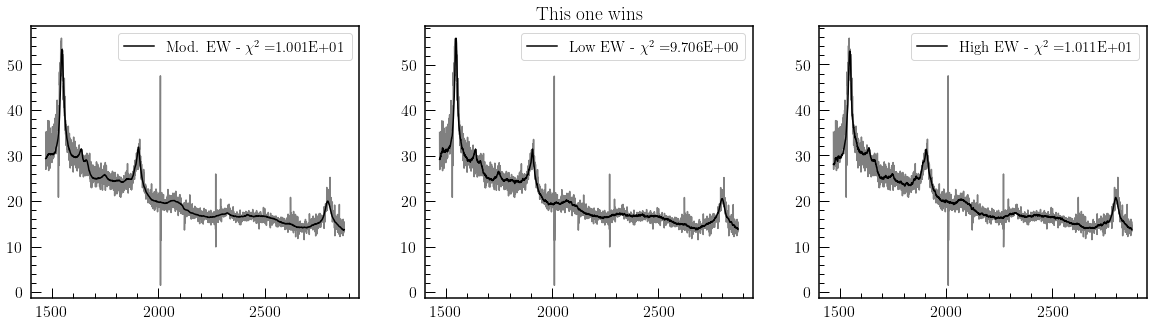

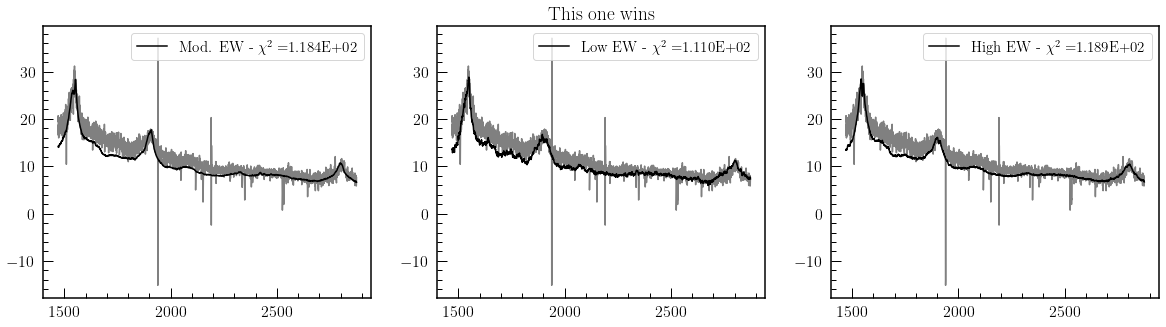

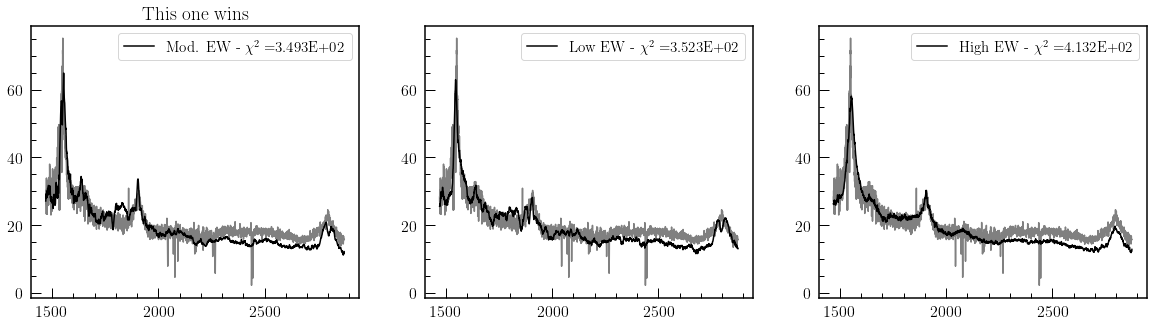

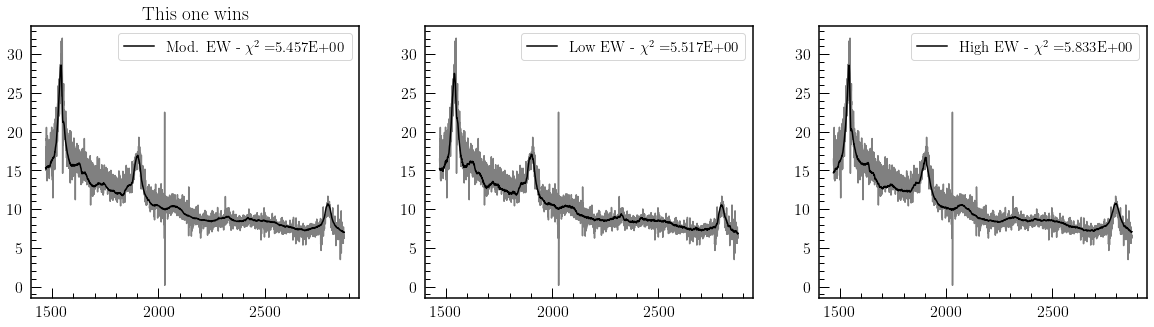

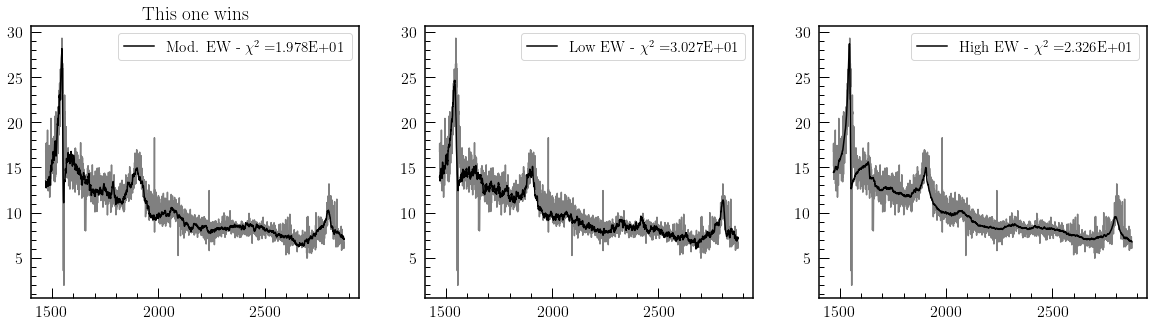

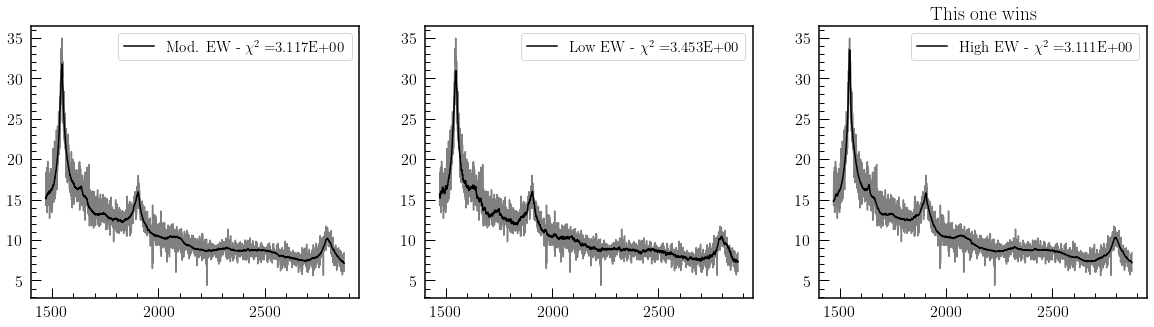

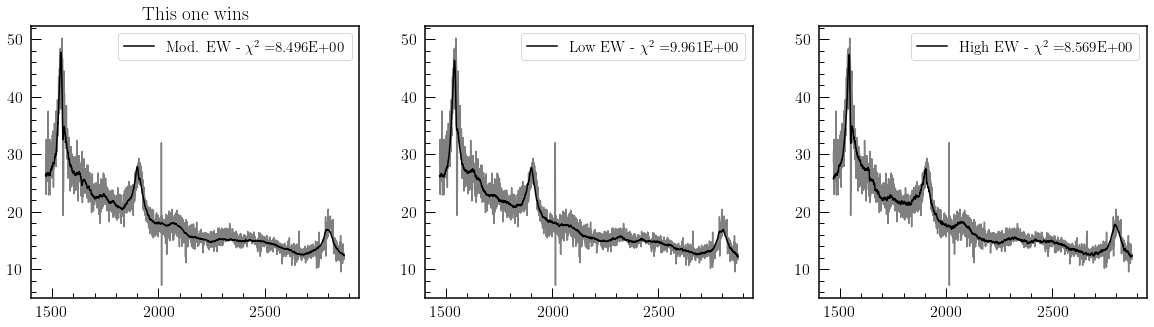

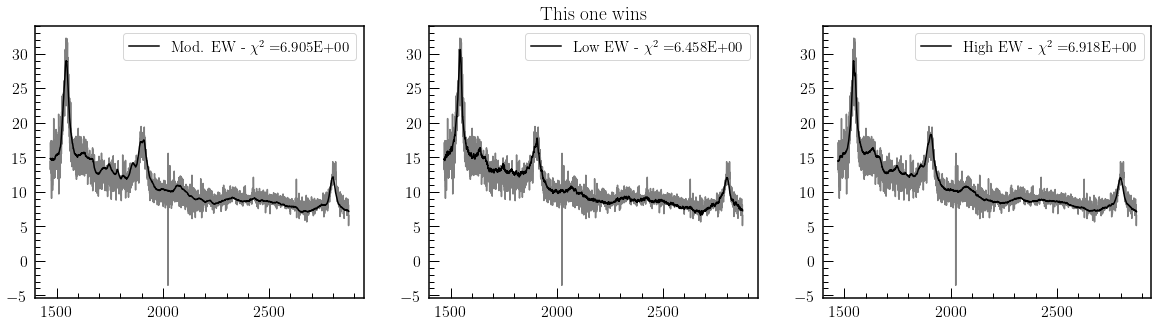

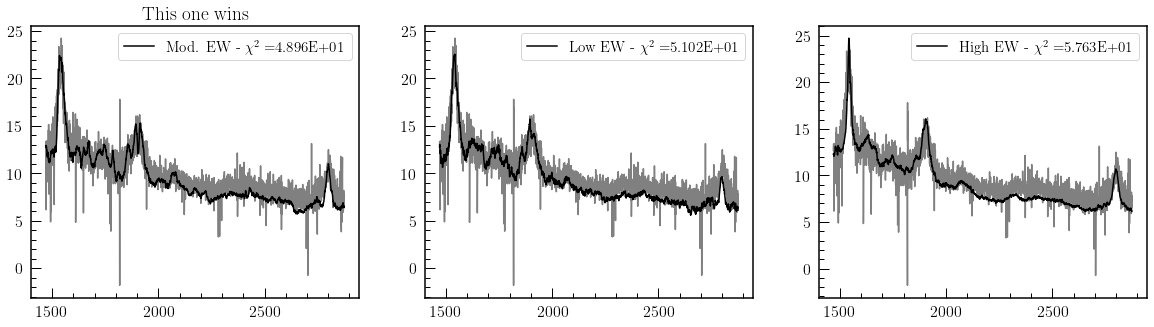

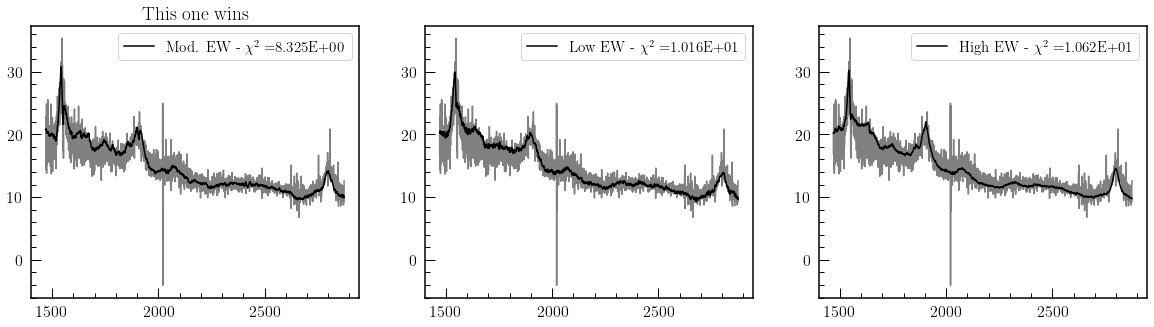

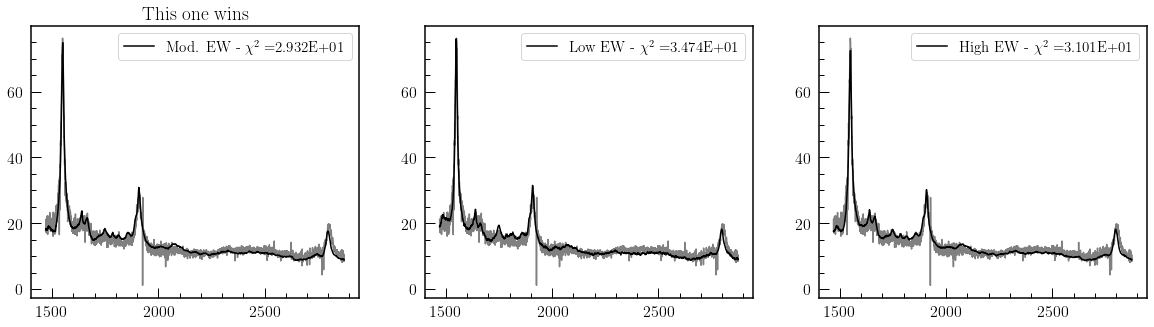

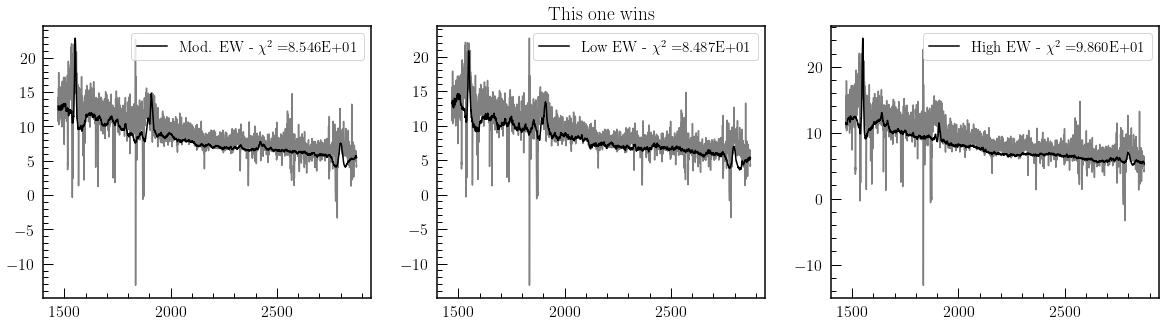

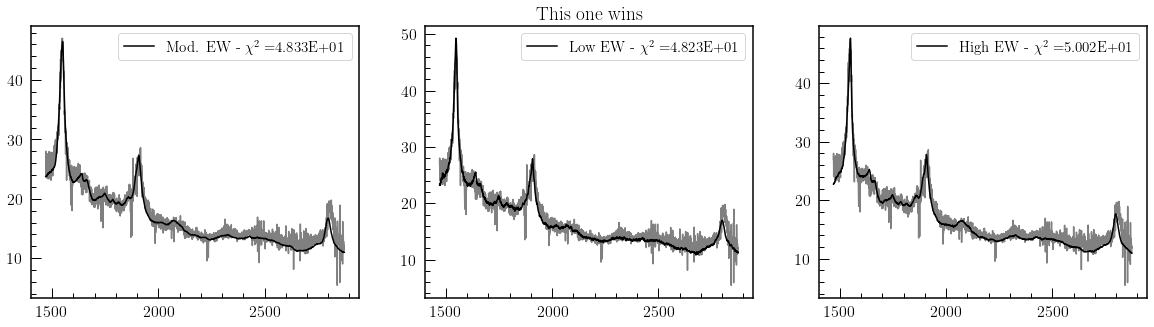

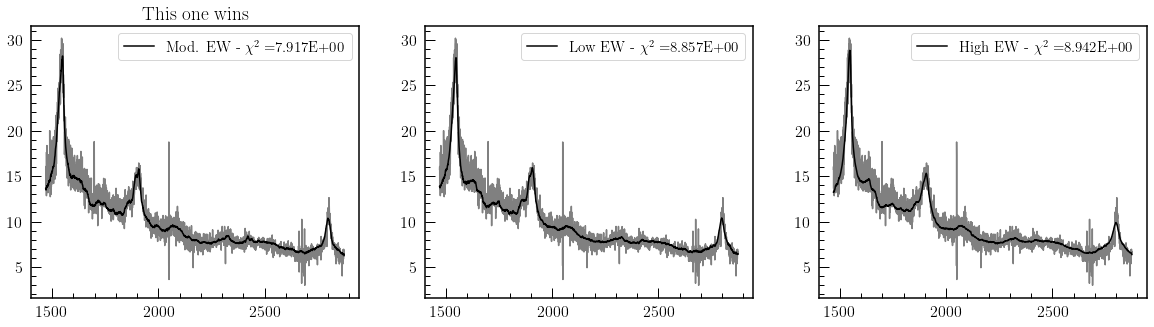

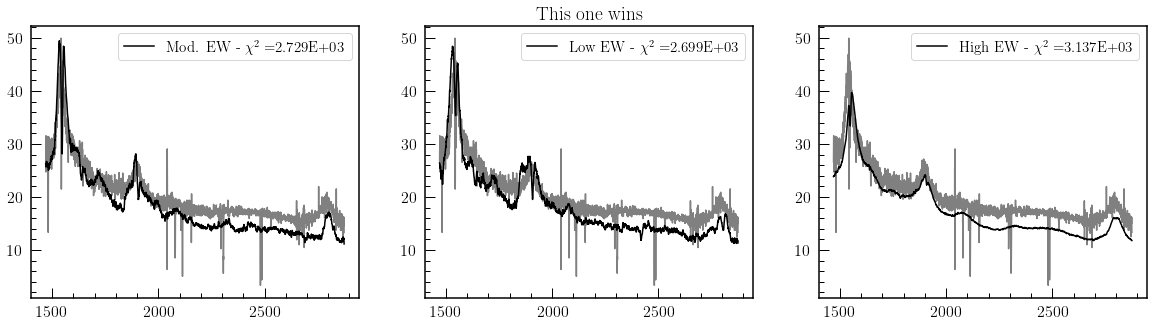

In [14]:
for k in range(15):
    fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(20,5))

    fit_mod   = ica_fit(components_mod, spectra[k], ivar[k])
    weights_mod = []
    for i in fit_mod.params: weights_mod.append(fit_mod.params[i].value)
    mod_chisq = fit_mod.redchi
    ax1.plot(wave_mod, spectra[k], '-', c='gray')
    ax1.plot(wave_mod, np.dot(weights_mod, components_mod), '-k', label="Mod. EW - $\chi^2=$%.3E" % (mod_chisq))
    ax1.legend(loc="best", prop={"size":15})

    fit_low   = ica_fit(components_low, spectra[k], ivar[k])
    weights_low = []
    for i in fit_low.params: weights_low.append(fit_low.params[i].value)
    low_chisq = fit_low.redchi
    ax2.plot(wave_low, spectra[k], '-', c='gray')
    ax2.plot(wave_low, np.dot(weights_low, components_low), '-k', label="Low EW - $\chi^2=$%.3E" % (low_chisq))
    ax2.legend(loc="best", prop={"size":15})

    fit_high   = ica_fit(components_high, spectra[k], ivar[k])
    weights_high = []
    for i in fit_high.params: weights_high.append(fit_high.params[i].value)
    high_chisq = fit_high.redchi
    ax3.plot(wave_high, spectra[k], '-', c='gray')
    ax3.plot(wave_high, np.dot(weights_high, components_high), '-k', label="High EW - $\chi^2=$%.3E" % (high_chisq))
    ax3.legend(loc="best", prop={"size":15})

    if mod_chisq < low_chisq and mod_chisq < high_chisq:
        ax1.set_title("This one wins")
    elif low_chisq < mod_chisq and low_chisq < high_chisq:
        ax2.set_title("This one wins")
    elif high_chisq < low_chisq and high_chisq < mod_chisq:
        ax3.set_title("This one wins")

    plt.show()

Not bad, but some still aren't really that great.  We should really be cleaning the spectra before giving them to ICA; I'm not sure that'll make a huge difference in determining the weights, but it's worth a try.

Amy also talks about "morphing" the spectra so they all have the same general shape.  I think they said that was specific to DR14 spectra (these are DR7), but we're going to want to extend this to DR14 eventually anyway, so should also figure that out.

They also use the morphology of CIII] and CIV to place priors on the weights, which supposedly greatly improves the reconstructions in the presence of strong absorption.

---

### Masking

These spectra cover the wavelength range 1470--2875 Å.  The masking procedure of Rankine et al. 2020 is as follows:

1. Mask the regions just blueward of emission lines where troughs are likely to occur.  These are:
    - SiIV and OIV: 1295-1400Å
    - CIV: 1430-1546Å
    - AlIII: 1780-1880Å
    
    
2. Fit the components *to the unmasked parts* of the spectrum


3. After obtaining the reconstruction, create a new mask which will basically pick out noisy unwanted pixels.  For each pixel $cpix$, "if the majority of the pixels in [$cpix−30$,$cpix+30$] have (reconstruction − spectrum $F_\lambda$) > $N\sigma$ (N=2), then $cpix$ is masked" (What? The majority? How will that pick out individual bad pixels?)


4. Once the bad pixels have been identified, an extra 10 pixels are masked blueward and leftward of each of the masking regions.


Steps 2-4 are repeated iteratively until the mask converges (usually 2-3 iterations).  If no convergence after 10 iterations, the process is started from scratch at step 1 and the noise cutoff is increased in increments of 0.25, i.e., N += 0.25 after each iteration of steps 2-4.

In [15]:
spectra.mean(0)

array([18.92043429, 18.77326698, 18.44021214, ...,  8.11760587,
        8.02609148,  8.2776615 ])

In [97]:
(1/np.sqrt(ivar[0])) #this is sigma (noise)

array([2.32225967, 2.30258598, 2.25427295, ..., 0.74064655, 0.7284916 ,
       0.87679842])

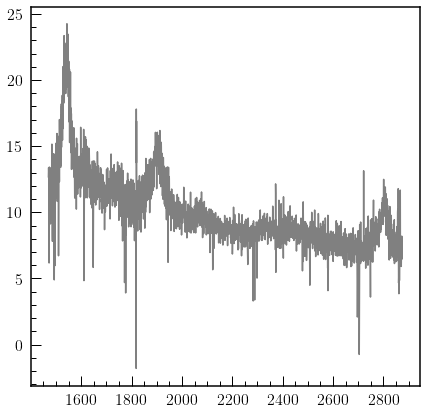

In [114]:
ind = 8 #test with this object
plt.plot(wave_mod, spectra[ind], '-', c='gray')

In [123]:
#The mask is just the pixels that the reconstruction should ignore
mask = np.zeros(len(spectra[ind]))

CIV   = np.array(((wave_mod>1430) & (wave_mod<1546))).flatten()
AiIII = np.array(((wave_mod>1780) & (wave_mod<1880))).flatten()

#mask[CIV|AiIII] = 1
mask[AiIII] = 1
mask = mask!=1

#Now run ICA on only the unmasked part of the spectrum
fit_mod = ica_fit(components_mod[:,mask], spectra[ind,mask], ivar[ind,mask])

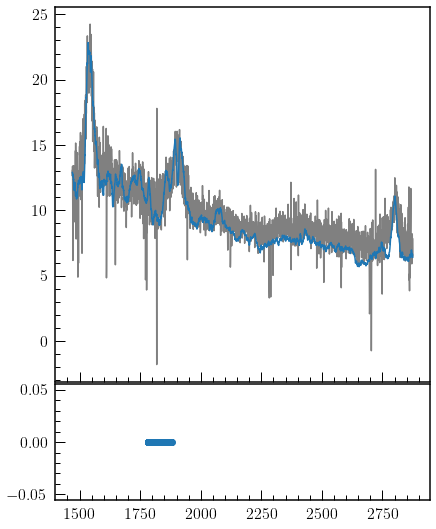

In [124]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.3, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom - 0.2 - spacing, width, 0.2]
#rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)

#Plot the spectrum and its reconstruction
weights_mod = []
for i in fit_mod.params: weights_mod.append(fit_mod.params[i].value)
ax.plot(wave_mod, spectra[ind], '-', c='gray')
ax.plot(wave_mod, np.dot(weights_mod, components_mod))

# Plot the masked pixels
ax_histx.scatter(wave_mod[~mask], np.zeros(len(wave_mod[~mask])))

plt.show()

Seems like that part went well-- now mask the actual noisy pixels...

In [125]:
reconst = np.dot(weights_mod, components_mod)
sigma   = 1 / np.sqrt(ivar[ind])

In [126]:
n = 2.5
for i in range(len(spectra[ind])):
    if (reconst[i] - spectra[ind][i]) > n*sigma[i]:
        mask[i-5:i+5] = False

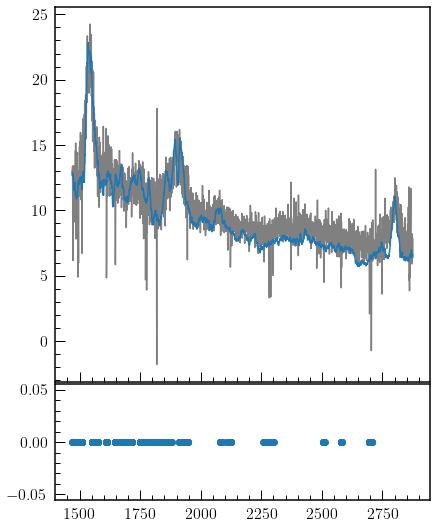

In [127]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.3, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom - 0.2 - spacing, width, 0.2]
#rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)

#Plot the spectrum and its reconstruction
weights_mod = []
for i in fit_mod.params: weights_mod.append(fit_mod.params[i].value)
ax.plot(wave_mod, spectra[ind], '-', c='gray')
ax.plot(wave_mod, np.dot(weights_mod, components_mod))

# Plot the masked pixels
ax_histx.scatter(wave_mod[~mask], np.zeros(len(wave_mod[~mask])))

plt.show()

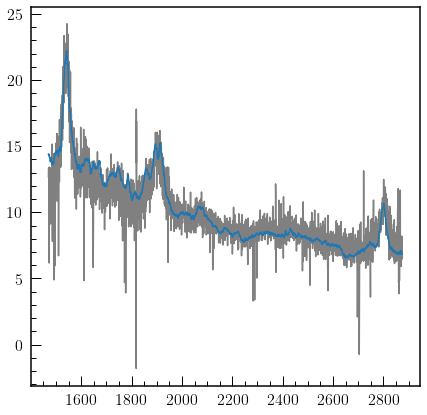

In [128]:
#Now run ICA on only the unmasked part of the spectrum
fit_mod = ica_fit(components_mod[:,mask], spectra[ind,mask], ivar[ind,mask])

#Plot the spectrum and its reconstruction
weights_mod = []
for i in fit_mod.params: weights_mod.append(fit_mod.params[i].value)
plt.plot(wave_mod, spectra[ind], '-', c='gray')
plt.plot(wave_mod, np.dot(weights_mod, components_mod))

That fixed the negative noise spikes "weighing down" the reconstruction, but at the cost of not doing a good job modeling the CIV line...

CHANGE: I removed the CIV part of the spectrum from the mask.  Mostly because we don't have enough information blueward of CIV (Amy did) to be masking it.

Throw it in a function- then can call it within the ICA fit.

In [136]:
def mask(components, wave, spectrum, ivar):
    #The mask is just the pixels that the reconstruction should ignore
    mask = np.zeros(len(spectrum))

    CIV   = np.array(((wave_mod>1430) & (wave_mod<1546))).flatten()
    AiIII = np.array(((wave_mod>1780) & (wave_mod<1880))).flatten()

    #mask[CIV|AiIII] = 1
    #mask[AiIII] = 1
    mask = mask!=1

    #Now run ICA on only the unmasked part of the spectrum
    fit = ica_fit(components[:,mask], spectrum[mask], ivar[mask])
    
    weights = []
    for i in fit.params: weights.append(fit.params[i].value)
        
    reconst = np.dot(weights, components)
    sigma   = 1 / np.sqrt(ivar)
    
    n = 2.5
    for i in range(len(spectrum)):
        if (reconst[i] - spectrum[i]) > n*sigma[i]:
            mask[i-5:i+5] = False
            
    return mask


def residual(params, comps, data, eps_data):
    model = sum(params[w].value*comps[n] for (n, w) in enumerate(params))
    return (data-model)**2 * eps_data


def ICA_fit(components, wave, spectrum, ivar):
    params = Parameters()
    for i in range(len(components)):
        params.add('W%d' % (i+1), value=0)
        
    MASK = mask(components, wave, spectrum, ivar)
    
    return minimize(residual, params, args=(components[:,MASK], spectrum[MASK], ivar[MASK]), method="lbfgsb")

In [137]:
fit = ICA_fit(components_mod, wave_mod, spectra[ind], ivar[ind])

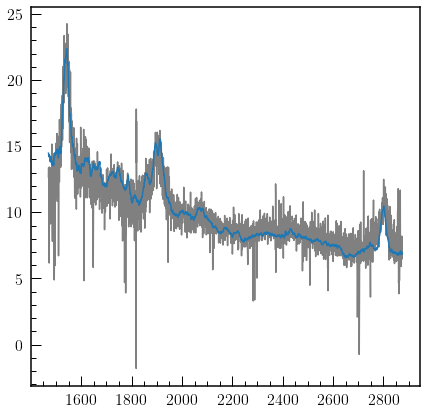

In [138]:
#Plot the spectrum and its reconstruction
weights = []
for i in fit.params: weights.append(fit.params[i].value)
plt.plot(wave_mod, spectra[ind], '-', c='gray')
plt.plot(wave_mod, np.dot(weights, components_mod))

Great, now that it's in functional form, see how the masking procedure improves the reconstructions of other objects.

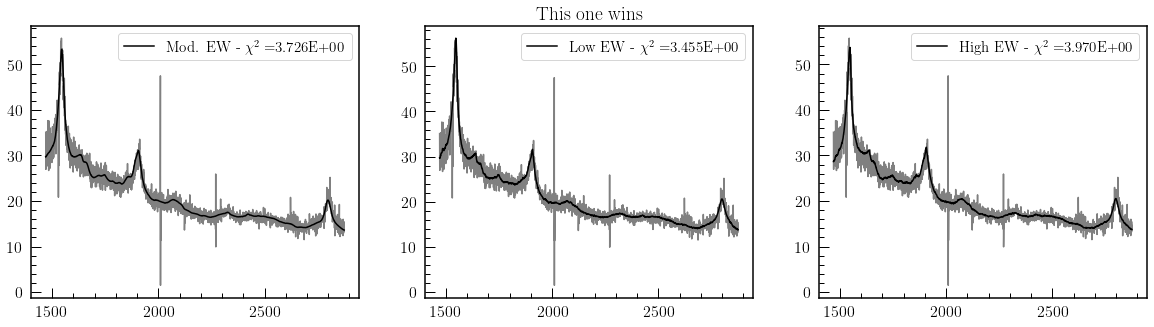

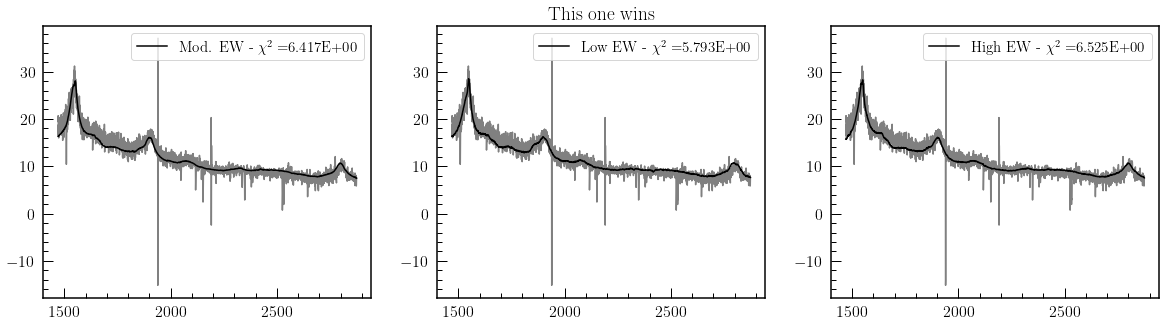

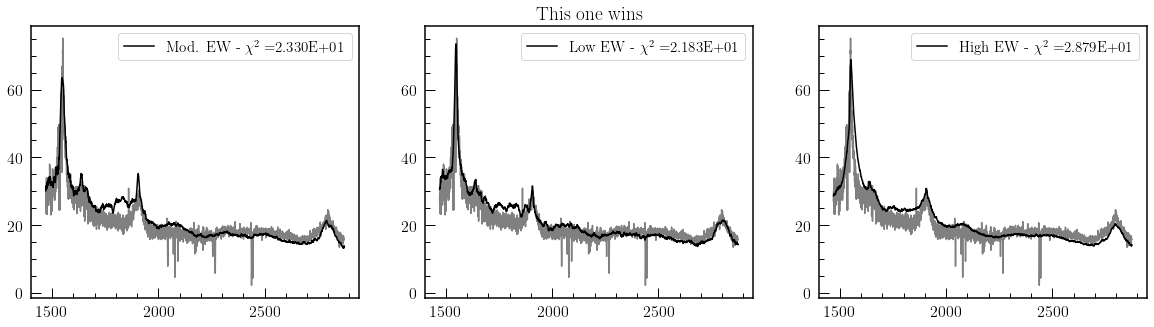

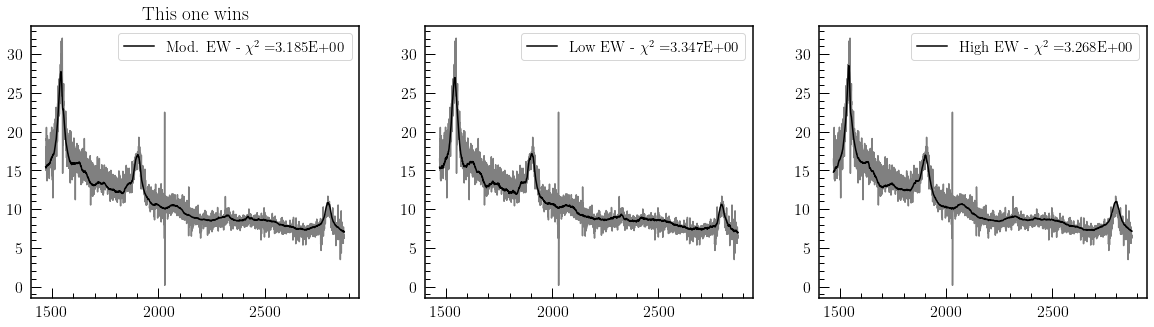

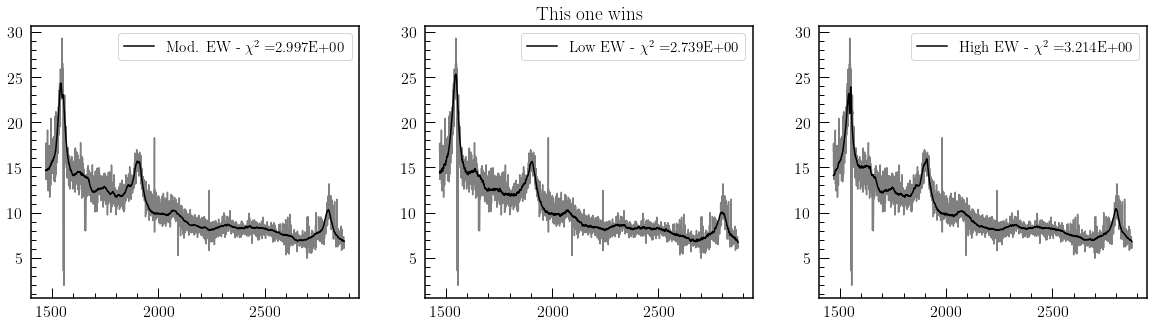

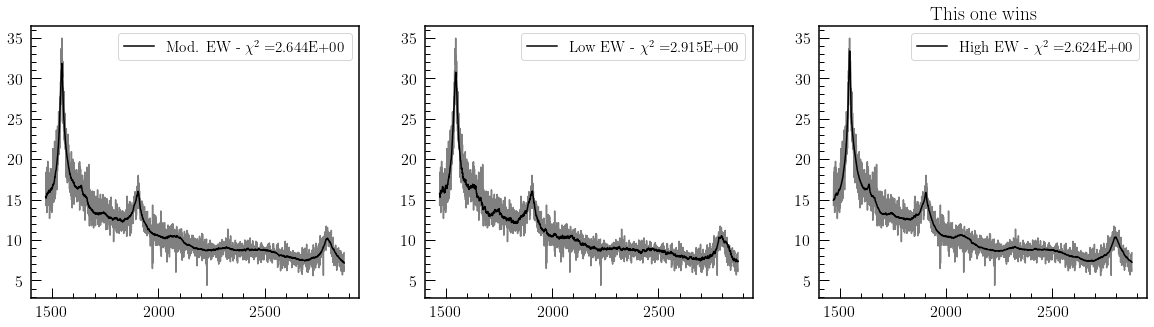

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


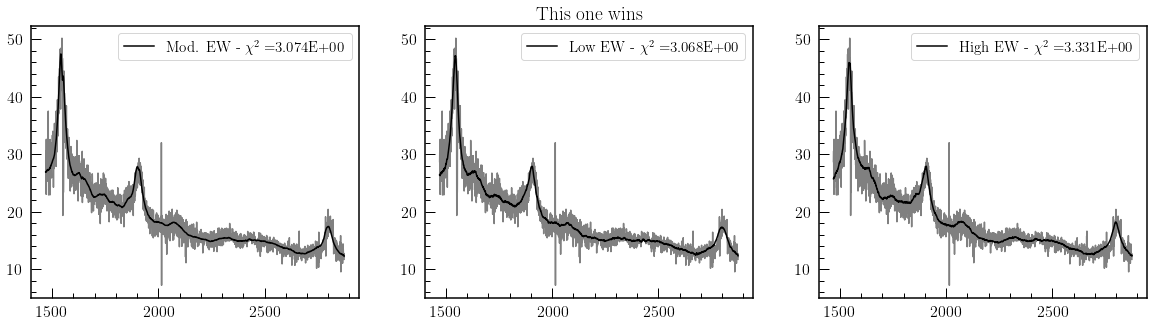

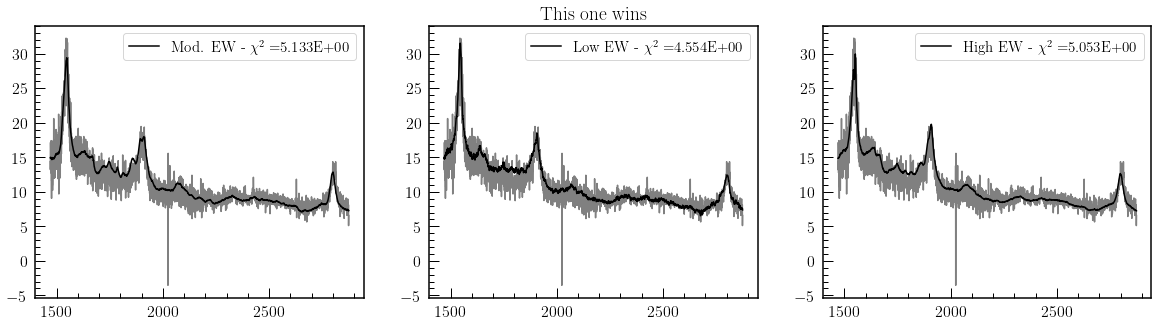

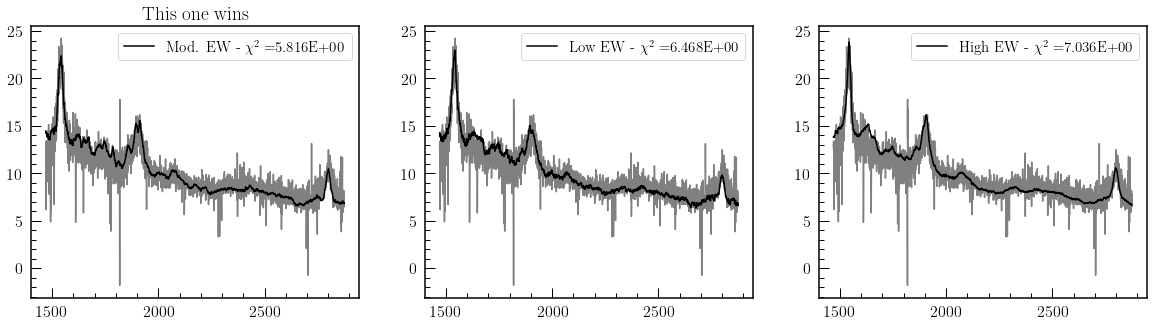

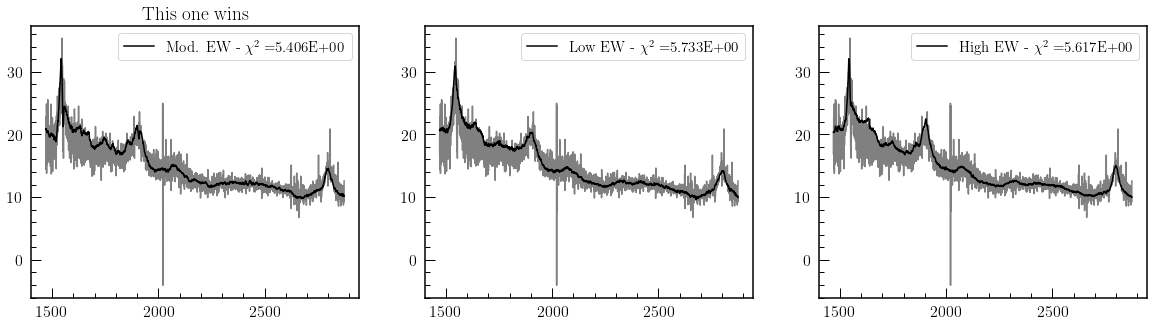

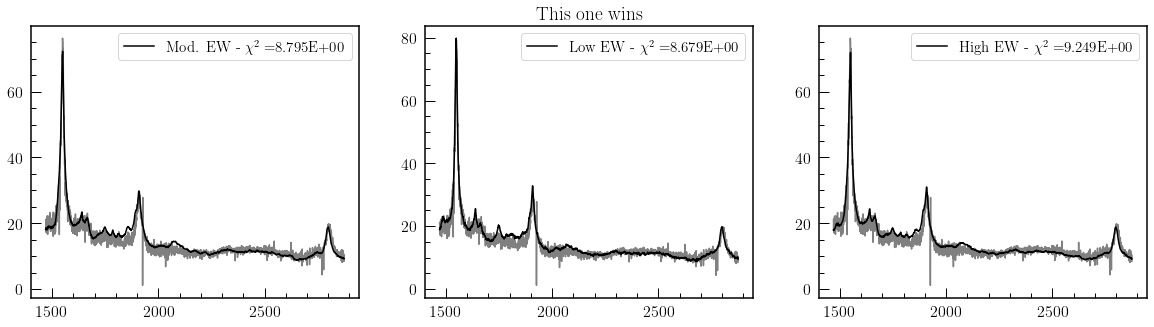

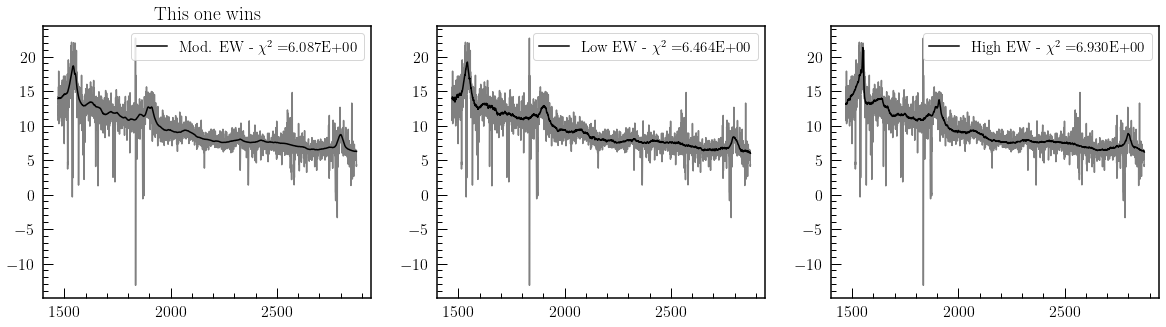

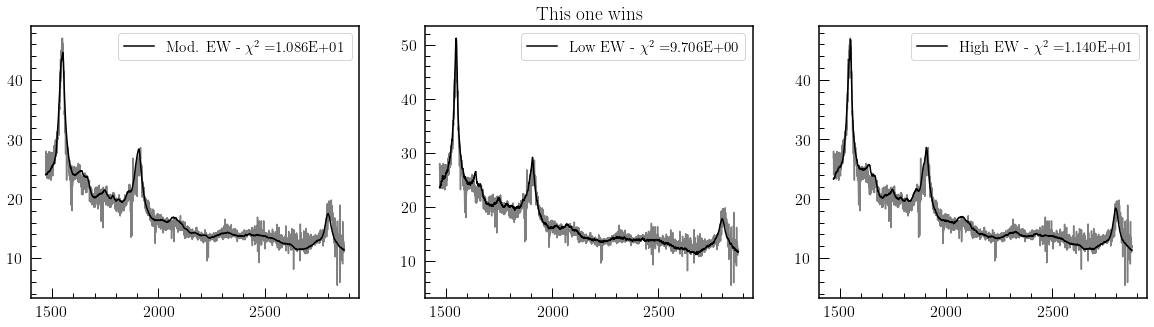

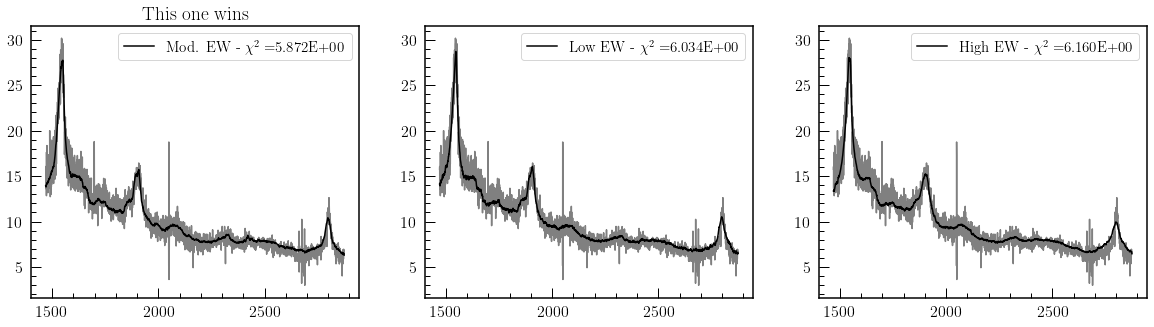

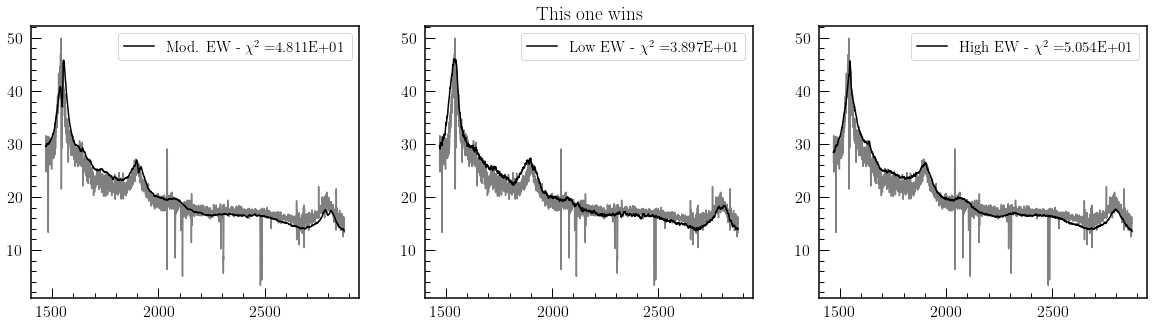

In [143]:
for k in range(15):
    fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(20,5))

    fit_mod   = ICA_fit(components_mod, wave_mod, spectra[k], ivar[k])
    weights_mod = []
    for i in fit_mod.params: weights_mod.append(fit_mod.params[i].value)
    mod_chisq = fit_mod.redchi
    ax1.plot(wave_mod, spectra[k], '-', c='gray')
    ax1.plot(wave_mod, np.dot(weights_mod, components_mod), '-k', label="Mod. EW - $\chi^2=$%.3E" % (mod_chisq))
    ax1.legend(loc="best", prop={"size":15})

    fit_low   = ICA_fit(components_low, wave_low, spectra[k], ivar[k])
    weights_low = []
    for i in fit_low.params: weights_low.append(fit_low.params[i].value)
    low_chisq = fit_low.redchi
    ax2.plot(wave_low, spectra[k], '-', c='gray')
    ax2.plot(wave_low, np.dot(weights_low, components_low), '-k', label="Low EW - $\chi^2=$%.3E" % (low_chisq))
    ax2.legend(loc="best", prop={"size":15})

    fit_high   = ICA_fit(components_high, wave_high, spectra[k], ivar[k])
    weights_high = []
    for i in fit_high.params: weights_high.append(fit_high.params[i].value)
    high_chisq = fit_high.redchi
    ax3.plot(wave_high, spectra[k], '-', c='gray')
    ax3.plot(wave_high, np.dot(weights_high, components_high), '-k', label="High EW - $\chi^2=$%.3E" % (high_chisq))
    ax3.legend(loc="best", prop={"size":15})

    if mod_chisq < low_chisq and mod_chisq < high_chisq:
        ax1.set_title("This one wins")
    elif low_chisq < mod_chisq and low_chisq < high_chisq:
        ax2.set_title("This one wins")
        extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig('reconst.pdf', bbox_inches=extent.expanded(1.25, 1.25))
    elif high_chisq < low_chisq and high_chisq < mod_chisq:
        ax3.set_title("This one wins")

    plt.show()

It looks like in general it performs better with the masking, but there are some weird messups; maybe don't mask near CIII] automatically?

UPDATE:  I think that helped?  Most spectra really get a good reconstruction, but still room for improvement.  Not sure "morphing" (Rankine et al (2020, Sec. 4)) is really gonna help since these all seem to have the same general shape...

Next focus should be priors on the weights (but this may not help alot since they're directed at BALs).  The initial values are currently just set to 0.